<center>
<img src="../../img/ods_stickers.jpg">
## Open Machine Learning Course
<center>
Author: Yury Kashnitsky, Data Scientist at Mail.Ru Group

This material is subject to the terms and conditions of the license [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Free use is permitted for any non-comercial purpose with an obligatory indication of the names of the authors and of the source.

## <center>Assignment #6. Part 1
### <center> Beating benchmarks in "Catch Me If You Can: Intruder Detection through Webpage Session Tracking"
    
[Competition](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2). The task is to beat "Assignment 6 baseline".

In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.feature_extraction.text import TfidfVectorizer

Reading original data

In [2]:
PATH_TO_DATA = ('../../data')
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'), index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'), index_col='session_id')

In [3]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


In [4]:
import pickle

# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')


# Load websites dictionary
with open(os.path.join(PATH_TO_DATA, "site_dic.pkl"), "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
4557,scraperwiki.com
2138,eff.linternaute.com
31739,levi.imageg.net
781,www.iegallery.com
21237,lutes.upmc.fr


Separate target feature 

In [5]:
y = train_df['target']

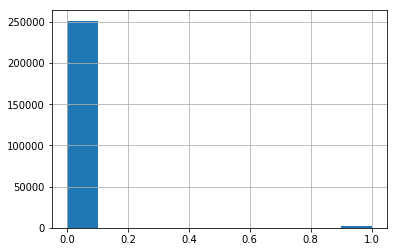

In [6]:
y.hist()

In [7]:
a = (y == 0).sum() 
b = (y == 1).sum()
a, b, b / (a + b)

(251264, 2297, 0.00905896411514389)

In [7]:
train_df[y == 0].head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,0,NaN,0,NaN,0,NaN,0,NaN,...,NaN,0,NaN,0,NaN,0,NaN,0,NaN,0
2,890,2014-02-22 11:19:50,941,2014-02-22 11:19:50,3847,2014-02-22 11:19:51,941,2014-02-22 11:19:51,942,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847,2014-02-22 11:19:52,3846,2014-02-22 11:19:52,1516,2014-02-22 11:20:15,1518,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39,2013-12-16 16:40:18,14768,2013-12-16 16:40:19,14769,2013-12-16 16:40:19,37,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768,2013-12-16 16:40:20,14768,2013-12-16 16:40:21,14768,2013-12-16 16:40:22,14768,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782,2014-03-28 10:52:42,782,2014-03-28 10:53:12,782,2014-03-28 10:53:42,782,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782,2014-03-28 10:55:12,782,2014-03-28 10:55:42,782,2014-03-28 10:56:12,782,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177,2014-02-28 10:55:22,175,2014-02-28 10:55:22,178,2014-02-28 10:55:23,177,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175,2014-02-28 10:55:59,177,2014-02-28 10:55:59,177,2014-02-28 10:57:06,178,2014-02-28 10:57:11,0


In [26]:
train_df[y == 1].head(10)

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
153,5397,2013-11-22 13:23:49,5395,2013-11-22 13:23:49,22,2013-11-22 13:23:50,5396,2013-11-22 13:23:50,5402,2013-11-22 13:23:50,...,2013-11-22 13:23:50,22,2013-11-22 13:23:51,35,2013-11-22 13:23:54,33,2013-11-22 13:23:54,338,2013-11-22 13:23:54,1
287,10941,2014-03-24 17:34:14,9783,2014-03-24 17:34:14,9786,2014-03-24 17:34:14,27339,2014-03-24 17:34:14,27338,2014-03-24 17:34:15,...,2014-03-24 17:34:15,27339,2014-03-24 17:34:15,9783,2014-03-24 17:34:15,9785,2014-03-24 17:34:15,10941,2014-03-24 17:34:15,1
430,37,2014-02-13 12:46:49,270,2014-02-13 12:48:14,32,2014-02-13 12:48:17,33,2014-02-13 12:48:18,35,2014-02-13 12:48:18,...,2014-02-13 12:48:23,29,2014-02-13 12:48:25,33,2014-02-13 12:48:48,12623,2014-02-13 12:48:48,704,2014-02-13 12:48:48,1
644,39,2014-02-17 16:42:03,23,2014-02-17 16:42:06,677,2014-02-17 16:42:08,22,2014-02-17 16:42:12,39,2014-02-17 16:42:12,...,2014-02-17 16:42:12,21,2014-02-17 16:42:12,678,2014-02-17 16:42:13,22,2014-02-17 16:42:15,678,2014-02-17 16:42:17,1
682,77,2013-09-12 16:21:55,879,2013-09-12 16:21:56,80,2013-09-12 16:21:58,879,2013-09-12 16:21:58,80,2013-09-12 16:22:04,...,2013-09-12 16:22:06,77,2013-09-12 16:22:10,879,2013-09-12 16:22:13,879,2013-09-12 16:22:14,80,2013-09-12 16:22:14,1
739,1057,2013-09-12 16:45:49,77,2013-09-12 16:45:50,80,2013-09-12 16:45:50,81,2013-09-12 16:45:50,76,2013-09-12 16:45:51,...,2013-09-12 16:45:53,81,2013-09-12 16:45:54,80,2013-09-12 16:45:55,81,2013-09-12 16:45:56,81,2013-09-12 16:45:57,1
1016,3240,2013-11-29 13:18:09,3241,2013-11-29 13:18:10,1116,2013-11-29 13:18:10,38,2013-11-29 13:18:11,1116,2013-11-29 13:18:11,...,2013-11-29 13:18:11,220,2013-11-29 13:18:12,29,2013-11-29 13:18:13,29,2013-11-29 13:18:14,3241,2013-11-29 13:18:15,1
1090,616,2013-04-12 09:11:38,23,2013-04-12 09:11:38,733,2013-04-12 09:11:39,774,2013-04-12 09:11:41,733,2013-04-12 09:11:42,...,2013-04-12 09:11:43,733,2013-04-12 09:11:47,3480,2013-04-12 09:12:57,27174,2013-04-12 09:13:43,23,2013-04-12 09:13:43,1
1127,5402,2014-02-17 18:08:05,5396,2014-02-17 18:08:05,107,2014-02-17 18:08:06,5397,2014-02-17 18:08:06,5394,2014-02-17 18:08:06,...,2014-02-17 18:08:06,5396,2014-02-17 18:08:06,2214,2014-02-17 18:08:06,5398,2014-02-17 18:08:06,5403,2014-02-17 18:08:06,1


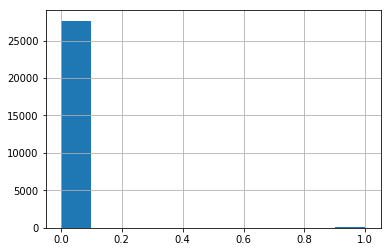

In [41]:
train_df[train_df[sites].duplicated()]['target'].hist()

In [114]:
train_sites = train_df[sites].values.flatten()
test_sites = test_df[sites].values.flatten()
good_sites = train_df[y == 0][sites].values.flatten()
bad_sites = train_df[y == 1][sites].values.flatten()

unique_train_sites = set(train_sites)
unique_test_sites = set(test_sites)
unique_good_sites = set(good_sites)
unique_bad_sites = set(bad_sites)

In [115]:
len(unique_train_sites), len(unique_test_sites), len(unique_good_sites), len(unique_bad_sites)

(41602, 15858, 41412, 1054)

In [129]:
res = unique_test_sites - unique_train_sites
len(res)

6770

In [131]:
len(site_dict), (len(unique_train_sites) + len(res))

(48371, 48372)

## Create features

Build Tf-Idf features based on sites. You can use `ngram_range`=(1, 3) and `max_features`=100000 or more

Let a session be a "document" and site - "term". Let `f(site, session)` be a number of times site appears in the session.
```
tf(site, session) = log(1 + f(site, session))
tfidf(site, session, all_sessions) = log(1 + N/nt)
```

Ref: [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

In [195]:
full_df = pd.concat([train_df.drop('target', axis=1), test_df], ignore_index=True)
sites_full = full_df[sites]
train_indices = sites_full.index[:len(train_df)]
test_indices = sites_full.index[len(train_df):]

In [196]:
sites_full.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
0,718,0,0,0,0,0,0,0,0,0
1,890,941,3847,941,942,3846,3847,3846,1516,1518
2,14769,39,14768,14769,37,39,14768,14768,14768,14768
3,782,782,782,782,782,782,782,782,782,782
4,22,177,175,178,177,178,175,177,177,178


In [197]:
for site_id in sites:
    print(" . ", end='')
    sites_full[site_id] = sites_full[site_id].apply(lambda x: sites_dict['site'][x] + " " if x > 0 else "")

 .  .  .  .  .  .  .  .  .  . 

In [198]:
sites_full_aligned = sites_full.loc[:, :].sum(axis=1)

In [200]:
sites_full_aligned.head()

0                             rr.office.microsoft.com 
1    maps.google.com mts0.google.com khms0.google.c...
2    cbk1.googleapis.com accounts.google.com cbk0.g...
3    annotathon.org annotathon.org annotathon.org a...
4    apis.google.com fr.wikipedia.org bits.wikimedi...
dtype: object

In [201]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect0 = TfidfVectorizer(max_features=1000000, ngram_range=(1,3))
vect0.fit(sites_full_aligned)


# def tokenizer(s):
#     return s.split(" ")
# vect1 = TfidfVectorizer(max_features=1000000, ngram_range=(1,2), tokenizer=tokenizer)
# vect1.fit(sites_full_aligned)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=1000000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [202]:
len(vect0.vocabulary_)

457500

In [206]:
train_sites_tfidf = vect0.transform(sites_full_aligned[train_indices])
test_sites_tfidf = vect0.transform(sites_full_aligned[test_indices])

Built features:

In [212]:
vect0.vocabulary_

{'mmotraffic com fr': 299159,
 '30120eccehomo eu www': 27277,
 '10165 454678809 init': 10591,
 'footers astralmedia com': 189672,
 'com webbooking louvre': 135334,
 '11074 638645016': 15264,
 'cedexis com pp': 90508,
 'ados fr i44': 50940,
 'www vu': 448812,
 'com sspcash adxcore': 130942,
 'hazebrouck fr': 243212,
 'com playerone': 126949,
 'fr www betclic': 210887,
 'ea': 165729,
 'cid 298f8b82cced0489': 94326,
 'babylon com boutiquepro': 67213,
 'jeune net info': 264156,
 'viadeo com fastly': 412335,
 'fr www notrefamille': 214589,
 'net widget5': 317694,
 'fr s1 fourmizzz': 206333,
 'grdf fr www': 240502,
 'boutique letemps': 79883,
 'expert com twitter': 178721,
 'amd4u com www': 57910,
 'pages2 marketo com': 339571,
 'alexandremohr free': 55108,
 'com perso0': 126392,
 'www bo girondins': 427300,
 'lkcss': 283008,
 'fr lemag zepass': 201691,
 'google com africanleadershipcon': 226700,
 'ytimg com files': 455249,
 'www medsci': 439487,
 'ulaval ca javadl': 405379,
 'org s2 wp': 33

tf-idf of a site URL in sessions:

In [213]:
sites_full_aligned[:10]

0                             rr.office.microsoft.com 
1    maps.google.com mts0.google.com khms0.google.c...
2    cbk1.googleapis.com accounts.google.com cbk0.g...
3    annotathon.org annotathon.org annotathon.org a...
4    apis.google.com fr.wikipedia.org bits.wikimedi...
5    plus.google.com www.google.fr plus.google.com ...
6    translate.google.com www.google.com search.twi...
7    apis.google.com www.google.fr www.facebook.com...
8    cbks0.google.com maps.google.fr mts1.google.co...
9    ec.gc.ca clients1.google.fr plus.google.com ww...
dtype: object

In [215]:
train_sites_tfidf[:10, vect0.vocabulary_['office microsoft']].toarray()

array([[0.32633769],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ],
       [0.        ]])

max tf-df of a site URL over all sessions:

In [220]:
x = train_sites_tfidf[:, vect0.vocabulary_['bouyguestelecom fr']].toarray()
x[x > 0]

array([0.45757371, 0.1629334 , 0.43364752, 0.13544762, 0.23975667,
       0.16305122, 0.19571992, 0.24257542, 0.32787836, 0.22682801,
       0.11552033, 0.41139736, 0.48231686, 0.44496301, 0.19354646,
       0.34879063, 0.47492393, 0.1079255 , 0.26315018, 0.10569263,
       0.24082932, 0.3822334 , 0.18433901, 0.29867523, 0.04493128,
       0.32945762, 0.25788127, 0.24991235, 0.37007107, 0.09486212,
       0.12416682, 0.32951371, 0.43786292, 0.34002016, 0.39374614,
       0.44990661, 0.25486372, 0.41176561, 0.29551492, 0.23430732,
       0.32370752, 0.36685554, 0.20724546, 0.2946122 , 0.41995048,
       0.27195355, 0.06591913, 0.40242218, 0.24291033, 0.33072155,
       0.2848598 , 0.40198478, 0.22638562, 0.2062708 , 0.34199503,
       0.22228742, 0.40155102, 0.28364827, 0.42947042, 0.39749061,
       0.36609986, 0.0782446 , 0.36400178, 0.46364566, 0.28873722,
       0.46110026, 0.1039138 , 0.14146316, 0.33653196, 0.49822364,
       0.32423899, 0.40114542, 0.4183374 , 0.39063462, 0.42448

Site visited when y == 1

TfIdf from site id:

In [207]:
def add_custom_tfidf(df):
    for site_id in sites:
        df.loc[:, 'tf_%s' % site_id] = 0
        df.loc[:, 'tf_%s' % site_id] = np.log(1.0 + df.loc[:, sites].eq(df.loc[:, site_id], axis=0).sum(axis=1))

    N = len(df)
    for site_id in sites:
        df.loc[:, 'idf_%s' % site_id] = 0
        site_id_idf = np.log(1 + N / (1 + df[site_id].value_counts()))
        df.loc[:, 'idf_%s' % site_id] = df.loc[:, site_id].apply(lambda x: site_id_idf[x])

    for site_id in sites:
        df.loc[:, 'tfidf_%s' % site_id] = df.loc[:, 'tf_%s' % site_id] * df.loc[:, 'idf_%s' % site_id]


Add features based on the session start time: hour, whether it's morning, day or night and so on.

In [ ]:
times = ['time%s' % i for i in range(1, 11)]
for time_id in times:
    train_df[time_id] = pd.to_datetime(train_df[time_id])

def to_daytime(hour):
    if 7 <= hour < 11:
        return 0
    elif 11 <= hour < 17:
        return 1
    elif 17 <= hour < 24:
        return 2
    elif 0 <= hour < 7:
        return 3
    else:
        return -1

for i, time_id in enumerate(times):
    train_df.loc[:, 'daytime%i' % (i + 1)] = train_df.loc[:, time_id].apply(lambda x: to_daytime(x.hour))

In [211]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,daytime1,daytime2,daytime3,daytime4,daytime5,daytime6,daytime7,daytime8,daytime9,daytime10
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,0,NaT,0,NaT,0,NaT,0,NaT,...,0,-1,-1,-1,-1,-1,-1,-1,-1,-1
2,890,2014-02-22 11:19:50,941,2014-02-22 11:19:50,3847,2014-02-22 11:19:51,941,2014-02-22 11:19:51,942,2014-02-22 11:19:51,...,1,1,1,1,1,1,1,1,1,1
3,14769,2013-12-16 16:40:17,39,2013-12-16 16:40:18,14768,2013-12-16 16:40:19,14769,2013-12-16 16:40:19,37,2013-12-16 16:40:19,...,1,1,1,1,1,1,1,1,1,1
4,782,2014-03-28 10:52:12,782,2014-03-28 10:52:42,782,2014-03-28 10:53:12,782,2014-03-28 10:53:42,782,2014-03-28 10:54:12,...,0,0,0,0,0,0,0,0,0,0
5,22,2014-02-28 10:53:05,177,2014-02-28 10:55:22,175,2014-02-28 10:55:22,178,2014-02-28 10:55:23,177,2014-02-28 10:55:23,...,0,0,0,0,0,0,0,0,0,0


Scale this features and combine then with Tf-Idf based on sites (you'll need `scipy.sparse.hstack`)

In [223]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

for i, time_id in enumerate(times):
    train_df.loc[:, 'ndaytime%i' % (i + 1)] = MinMaxScaler().fit_transform(train_df['daytime%i' % (i + 1)].values.reshape(-1, 1))

In [225]:
ndaytimes = ['ndaytime%s' % i for i in range(1, 11)]
tfidfs = ['tfidf_site%s' % i for i in range(1, 11)]
# _X = train_df[tfidfs + ndaytimes]
_X = train_df[ndaytimes]

In [226]:
_X.head()

,ndaytime1,ndaytime2,ndaytime3,ndaytime4,ndaytime5,ndaytime6,ndaytime7,ndaytime8,ndaytime9,ndaytime10
session_id,,,,,,,,,,
1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.5,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
3,0.5,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
4,0.0,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333
5,0.0,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333


In [227]:
from scipy.sparse import hstack

In [228]:
train_sites_tfidf

<253561x457500 sparse matrix of type '<class 'numpy.float64'>'
	with 11210929 stored elements in Compressed Sparse Row format>

In [229]:
X = hstack([train_sites_tfidf, _X])
X

<253561x457510 sparse matrix of type '<class 'numpy.float64'>'
	with 13532682 stored elements in COOrdinate format>

In [231]:
def to_daytime(hour):
    if 7 <= hour < 11:
        return 0
    elif 11 <= hour < 17:
        return 1
    elif 17 <= hour < 24:
        return 2
    elif 0 <= hour < 7:
        return 3
    else:
        return -1
    
    
def add_timebased_features(X, df):
    
    times = ['time%s' % i for i in range(1, 11)]
    for time_id in times:
        df[time_id] = pd.to_datetime(df[time_id])

    for i, time_id in enumerate(times):
        df.loc[:, 'daytime%i' % (i + 1)] = df.loc[:, time_id].apply(lambda x: to_daytime(x.hour))

    for i, time_id in enumerate(times):
        df.loc[:, 'ndaytime%i' % (i + 1)] = MinMaxScaler().fit_transform(df['daytime%i' % (i + 1)].values.reshape(-1, 1))        
        
    ndaytimes = ['ndaytime%s' % i for i in range(1, 11)]
    X = hstack([X, df[ndaytimes]])
        
    return X

In [230]:
# def to_daytime(hour):
#     if 7 <= hour < 11:
#         return 0
#     elif 11 <= hour < 17:
#         return 1
#     elif 17 <= hour < 24:
#         return 2
#     elif 0 <= hour < 7:
#         return 3
#     else:
#         return -1
    
    
# def compute_features(df, vect=None, add_site_index_tfidf=True, add_timebased_features=True):
    
#     print("- Generate session URLs")
#     sites_full = df[sites]
#     for site_id in sites:
#         print(" . ", end='')
#         sites_full[site_id] = sites_full[site_id].apply(lambda x: sites_dict['site'][x] + " " if x > 0 else "")
#     print('')
    
#     sites_full_aligned = sites_full.loc[:, :].sum(axis=1)
#     def tokenizer(s):
#         return s.split(" ")
    
#     print("- Compute TF-IDF from session URLs")
#     if vect is None:
#         vect = TfidfVectorizer(max_features=1000000, ngram_range=(1,2), tokenizer=tokenizer)
#         vect.fit(sites_full_aligned)
#     sites_tfidf = vect.transform(sites_full_aligned)
    
#     X = sites_tfidf
    
#     if add_site_index_tfidf:
#         print("- Compute site index TF-IDF ")
#         for site_id in sites:
#             df.loc[:, 'tf_%s' % site_id] = 0
#             df.loc[:, 'tf_%s' % site_id] = np.log(1.0 + df.loc[:, sites].eq(df.loc[:, site_id], axis=0).sum(axis=1))

#         N = len(df)
#         for site_id in sites:
#             df.loc[:, 'idf_%s' % site_id] = 0
#             site_id_idf = np.log(1 + N / (1 + df[site_id].value_counts()))
#             df.loc[:, 'idf_%s' % site_id] = df.loc[:, site_id].apply(lambda x: site_id_idf[x])
#         for site_id in sites:
#             df.loc[:, 'tfidf_%s' % site_id] = df.loc[:, 'tf_%s' % site_id] * df.loc[:, 'idf_%s' % site_id]
        
#         tfidfs = ['tfidf_site%s' % i for i in range(1, 11)]
#         X = hstack([X, df[tfidfs]])

#     if add_timebased_features:
#         print("- Compute timebased features")
#         times = ['time%s' % i for i in range(1, 11)]
#         for time_id in times:
#             df[time_id] = pd.to_datetime(df[time_id])
            
#         for i, time_id in enumerate(times):
#             df.loc[:, 'daytime%i' % (i + 1)] = df.loc[:, time_id].apply(lambda x: to_daytime(x.hour))
        
#         for i, time_id in enumerate(times):
#             df.loc[:, 'ndaytime%i' % (i + 1)] = MinMaxScaler().fit_transform(df['daytime%i' % (i + 1)].values.reshape(-1, 1))        
        
#         ndaytimes = ['ndaytime%s' % i for i in range(1, 11)]
#         X = hstack([X, df[ndaytimes]])
        
#     return X, vect

In [232]:
X = add_timebased_features(train_sites_tfidf, train_df)
X.shape

(253561, 457510)

Perform cross-validation with logistic regression.

In [233]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=42)

log_reg_cv = LogisticRegressionCV(cv=skf, class_weight='balanced', scoring='roc_auc', 
                                  random_state=42, verbose=True, n_jobs=-1)

In [234]:
os.environ['JOBLIB_TEMP_FOLDER']="/tmp"

In [ ]:
log_reg_cv.fit(X, y)

In [271]:
np.mean(log_reg_cv.scores_[1], axis=0), log_reg_cv.C_

(array([0.94941963, 0.96271558, 0.9640408 , 0.96815804, 0.96733427,
        0.96963477, 0.96864157, 0.97001818, 0.96936901, 0.96964759,
        0.96934405]), array([5000.]))

**Results:**

378190 tfidf features ngrams=(1, 2) + Site index custom tfidfs + ndaytimes

```
(array([0.82081921, 0.87437643, 0.91980717, 0.95257225, 0.96356551,
        0.96590507, 0.96786151, 0.96781816, 0.96936538, 0.96860388]),
 array([1291.54966501]))
 ```

378190 tfidf features ngrams=(1, 2)

`(array([0.88413484, 0.89676234, 0.92163549, 0.94630596, 0.95751679,
        0.95765139, 0.94786301, 0.93324887, 0.91174217, 0.91658067]),
 array([2.7825594]))`

100 tfidf site features

`array([0.84036089, 0.86739761, 0.88847426, 0.89525702, 0.89740772,
       0.89863011, 0.89907569, 0.89975907, 0.8995833 , 0.89978664])`

Site index custom tfidfs + ndaytimes

```
(array([0.761606  , 0.76186965, 0.76305951, 0.76328609, 0.76290517,
        0.76260131, 0.76257309, 0.7625813 , 0.76258039, 0.76259375]),
 array([0.04641589]))
```

Train a model

In [273]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(C=log_reg_cv.C_[0], class_weight='balanced', n_jobs=-1)
log_reg.fit(X, y)

LogisticRegression(C=5000.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=-1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Make prediction for the test set and form a submission file.

In [256]:
X_test, vect = compute_features(test_df, vect=vect)

- Generate session URLs
 .  .  .  .  .  .  .  .  .  . - Compute TF-IDF from session URLs
- Compute site index TF-IDF 
- Compute timebased features


In [259]:
X_test.shape

(82797, 378210)

In [274]:
test_pred = log_reg.predict(X_test)

In [275]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)


In [276]:
write_to_submission_file(test_pred, "assignment6_alice_submission2.csv")

In [279]:
!tail assignment6_alice_submission2.csv

82788,0
82789,0
82790,0
82791,0
82792,0
82793,0
82794,0
82795,0
82796,0
82797,0


In [280]:
!tail assignment6_alice_submission2.csv

82788,0
82789,0
82790,0
82791,0
82792,0
82793,0
82794,0
82795,0
82796,0
82797,0
